In [1]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
from seaborn import histplot
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config
from astropy.time import Time
from astropy.coordinates import EarthLocation,SkyCoord, AltAz 
import time
from ctapipe.image import number_of_island_sizes
from ctapipe.image import (
    hillas_parameters,
    leakage_parameters,
    concentration_parameters,
)
from ctapipe.image import timing_parameters
from ctapipe.image import number_of_islands
from ctapipe.image import camera_to_shower_coordinates
import ctapipe
from lstchain.io import replace_config, standard_config
import h5py
from astropy.io import fits
import json
muon_rings = [434, 663, 949, 1295, 1355, 1565, 1777, 1933, 3067, 3179, 3270, 3314,3346, 3692, 4076,  5016, 6853, 7723, 7919, 8122, 8605, 9047, 9157, 9239, 9774,  9910, 10486, 10491, 11600, 11781, 12038, 12506, 12969, 13004, 13101] 
muon_rings_datacheck = [54110, 55656, 55942, 57623, 58136, 58798, 59194, 59570, 60407, 60422, 62395, 63033, 63412, 64971, 65272, 66251, 66737, 67143, 67175, 67772, 68483, 68495, 68755, 68902, 69300, 69891, 70855, 72398, 73259, 73261, 73725, 76581, 76871, 77277, 80267, 80982, 81229, 81606, 82140, 83970, 84318, 85580, 87424, 87427, 87921, 88388, 89632, 91351, 93414, 93971, 94651, 95006, 96661, 97072, 97242, 97335, 97713, 97785, 97891, 99847, 100267, 101084, 101156, 101606, 103028, 103475, 105020, 105713]
flagged_rings_sim = [5333507, 1673009, 1808303, 3362305, 2835508, 4026706, 159503, 4854202, 5464504, 2439702, 1402200, 3456509, 3547004, 2229705, 22604, 5573308, 3489206, 417000, 5895006, 1836008, 1794401, 593906, 3280901, 1114103, 5920700, 5521903, 5240406, 5678007, 918003, 5858809, 4315801, 3547006, 729206, 5412204, 759808, 3386907, 2597005, 3539901, 4125904, 1073405, 3662503, 846606, 2845905, 5139408, 5097001, 3248609, 2257305, 5559707, 1775404, 5586609, 5387503, 336801, 3611003, 4504102, 1556201, 3742006, 55203, 377809, 5303909, 3393108, 5854105, 3850800, 5240903, 5120108, 4330605, 4006201, 4752000, 817501, 1096109, 5562603, 3289408, 2057308, 1646106, 2736603, 220203, 2095301, 243205, 250008, 728702, 1177701, 402700, 4589808, 1063003, 3804102, 1088507, 5638409, 1824304, 2482107, 2619809, 4647903, 5864908, 4805401, 2936707, 996201]
len(muon_rings)
import os
import pickle


In [2]:
# Треба завантажити конфіг в івент соурс
filename = f'/Users/vdk/muons2024/muon_cleaning_2024/LST-1.1.Run16463.0001.fits.fz'

#int_cut = 0.3
#min_pixel = 30

config_filename = '/Users/vdk/CTA/RealLST/typical_run_data/lstchain_standard_v0.10_heuristic_ff.json'
with open(config_filename) as json_file:
    config_data = json.load(json_file)

custom_config = Config(config_data)


cfg = Config({
    "source_config": {
        "EventSource" : {
            "allowed_tels": [1],"max_events": 9999}},
        "PointingSource":{
            "drive_report_path": '/Users/vdk/muons2024/muon_cleaning_2024/DrivePosition_log_20240201.txt'},
        "LSTR0Corrections": {
          "calib_scale_high_gain":1.088,
          "calib_scale_low_gain":1.004,
          "drs4_pedestal_path": '/Users/vdk/muons2024/muon_cleaning_2024/drs4_pedestal.Run16453.0000.h5',
          "calibration_path": '/Users/vdk/muons2024/muon_cleaning_2024/calibration_filters_52.Run16454.0000.h5',
          "drs4_time_calibration_path": '/Users/vdk/muons2024/muon_cleaning_2024/time_calibration.Run15253.0000.h5'
      }})

# config = replace_config(standard_config, muon_processor_config)
# config = replace_config(config, muon_processor_config_2)
# config = replace_config(config, custom_config)


In [3]:
source = EventSource(filename, config = Config(cfg))

event_iterator = iter(source)
event = next(event_iterator)

event.index.event_id

59809

In [10]:
print(event)

{'calibration': {'tel': {1: {'dl1': {'absolute_factor': 1,
                                     'pedestal_offset': None,
                                     'relative_factor': array([1.088, 1.088, 1.088, ..., 1.088, 1.088, 1.088]),
                                     'time_shift': array([-0.00324605,  0.07230443,  1.38228533, ...,  0.78911279,
       -0.38061135, -0.46853288])}}}},
 'count': 0,
 'dl0': {'tel': {}},
 'dl1': {'tel': {}},
 'dl2': {'stereo': {'classification': {}, 'energy': {}, 'geometry': {}},
         'tel': {}},
 'index': {'event_id': 59809, 'obs_id': 16463},
 'lst': {'tel': {1: {'evt': {'calibration_monitoring_id': 0,
                             'charges_hg': array([], dtype=float64),
                             'charges_lg': array([], dtype=float64),
                             'chips_flags': array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
                             'configuration_id': None,
                             'drs_tag': None,
                           

In [16]:
event

ctapipe_io_lst.containers.LSTArrayEventContainer:
                       index.*: event indexing information with default None
                          r0.*: Raw Data with default None
                          r1.*: R1 Calibrated Data with default None
                         dl0.*: DL0 Data Volume Reduced Data with default None
                         dl1.*: DL1 Calibrated image with default None
                         dl2.*: DL2 reconstruction info with default None
                    simulation: Simulated Event Information with default None
                                with type <class
                                'ctapipe.containers.SimulatedEventContainer'>
                     trigger.*: central trigger information with default None
                         count: number of events processed with default 0
                    pointing.*: Array and telescope pointing positions with
                                default None
                 calibration.*: Container f

In [19]:
print(event.trigger)

{'event_type': <EventType.SKY_PEDESTAL: 2>,
 'tel': {1: {'n_trigger_pixels': -1,
             'time': <Time object: scale='tai' format='unix_tai' value=1706828056.2670004>,
             'trigger_pixels': None}},
 'tels_with_trigger': [1],
 'time': <Time object: scale='tai' format='unix_tai' value=1706828056.2670004>}


IndexError: index 2 is out of bounds for axis 0 with size 2

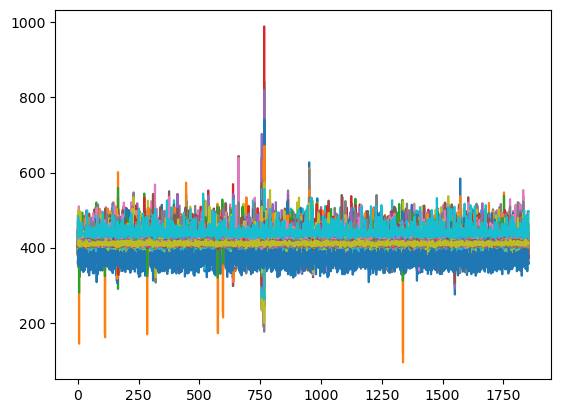

In [24]:
for pix_id in range(0,1764):
    plt.plot(event.r0.tel[1].waveform[pix_id], label="pix {}".format(pix_id), drawstyle='steps')

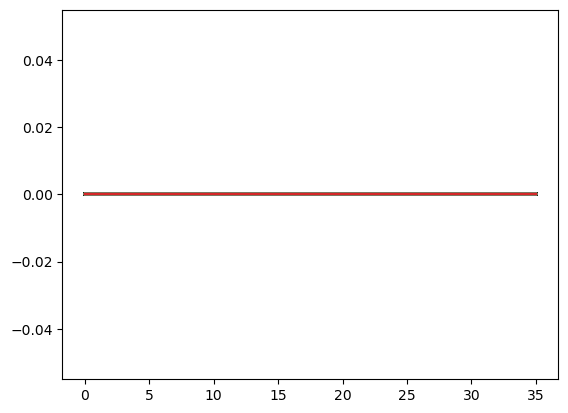

In [30]:
for pix_id in range(0,1764):
    plt.plot(event.r1.tel[1].waveform[pix_id], label="pix {}".format(pix_id), drawstyle='steps')

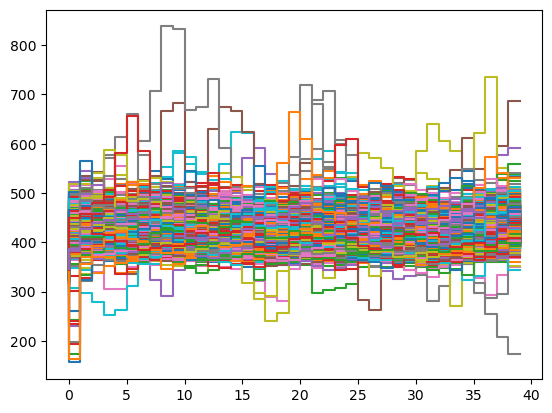

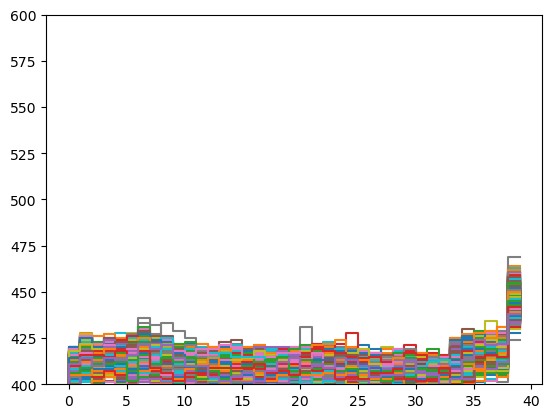

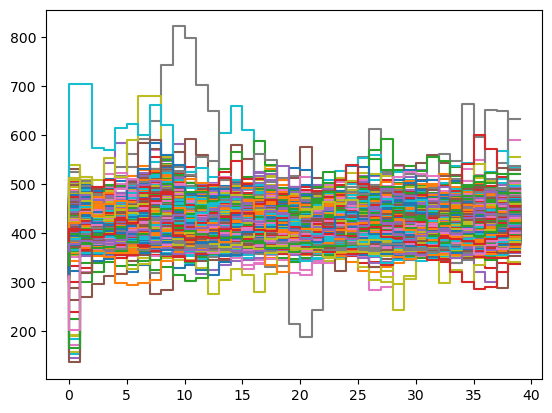

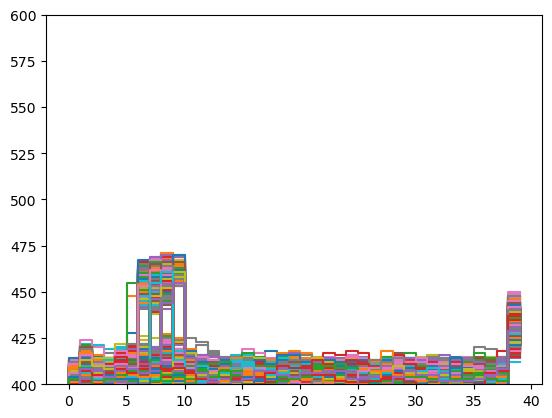

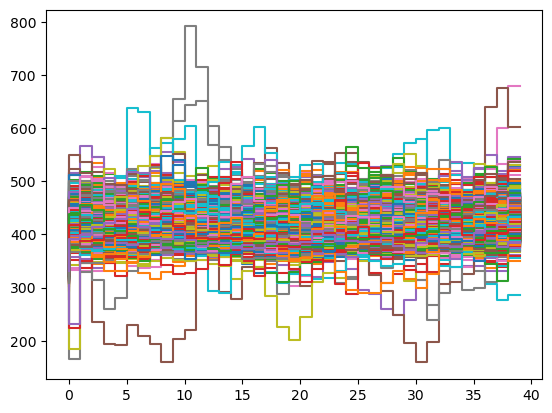

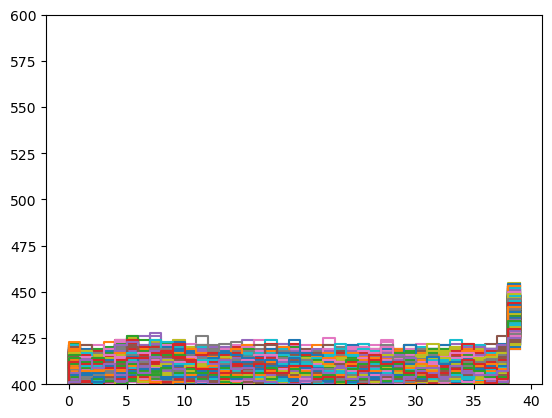

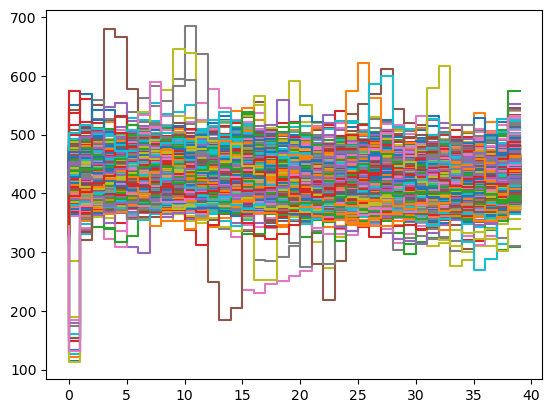

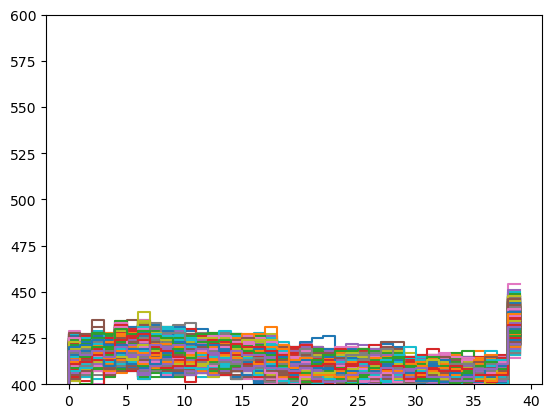

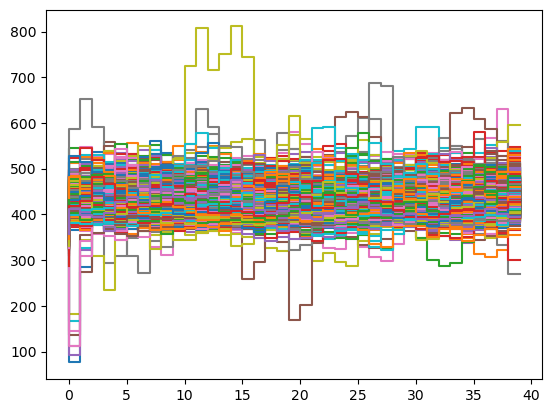

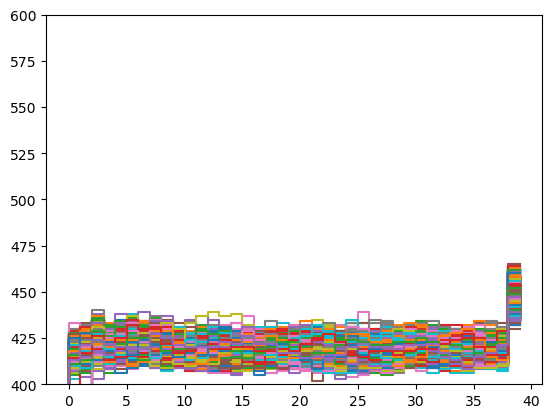

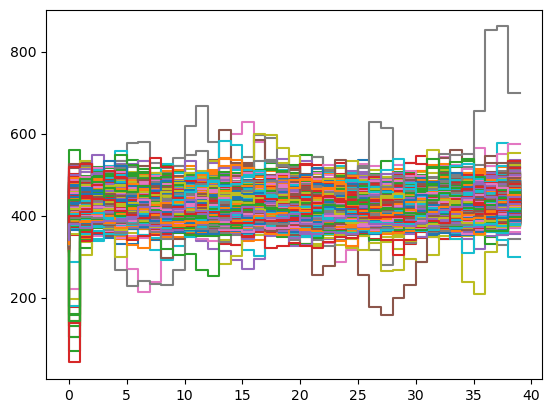

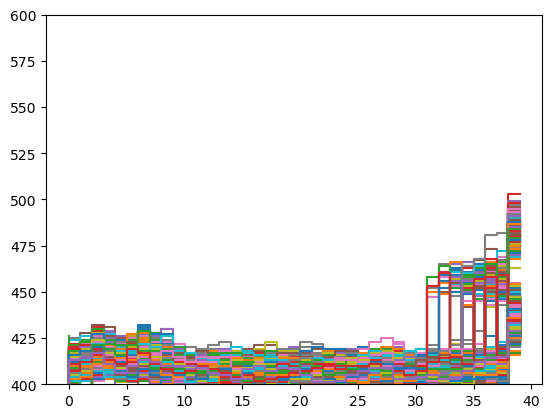

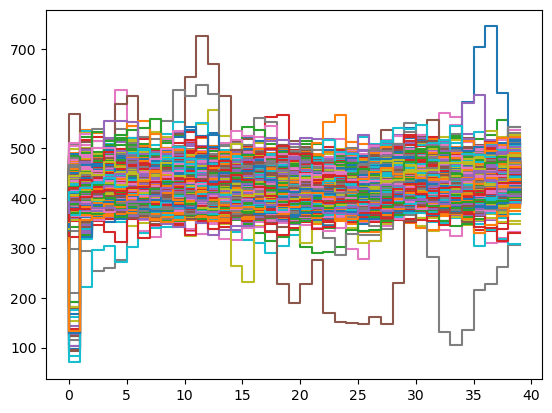

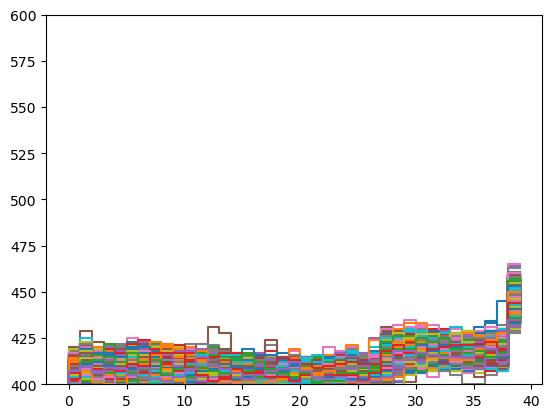

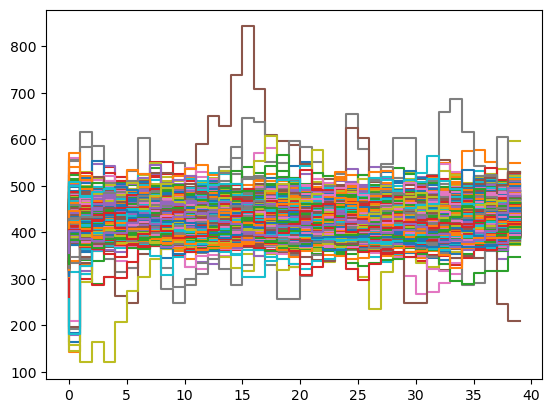

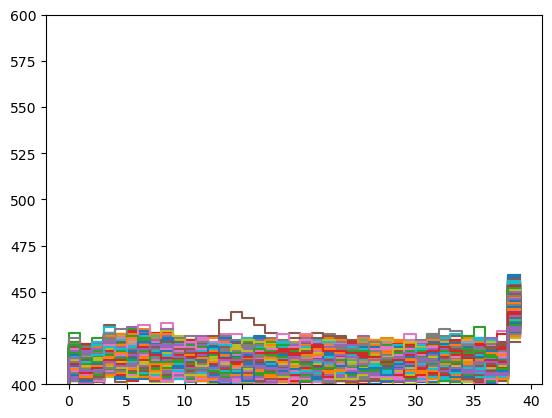

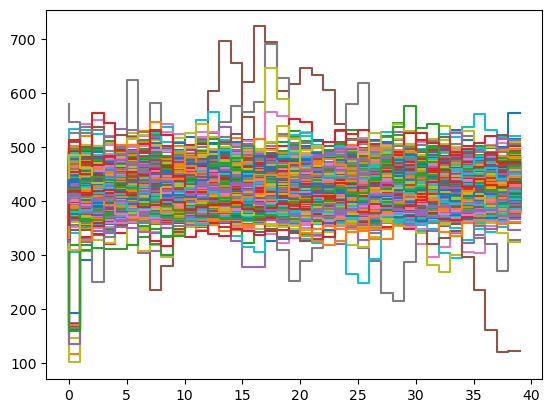

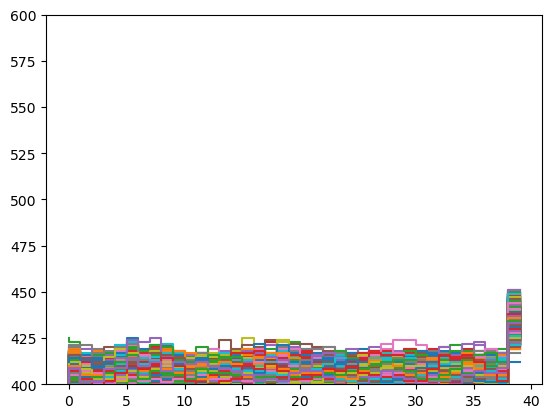

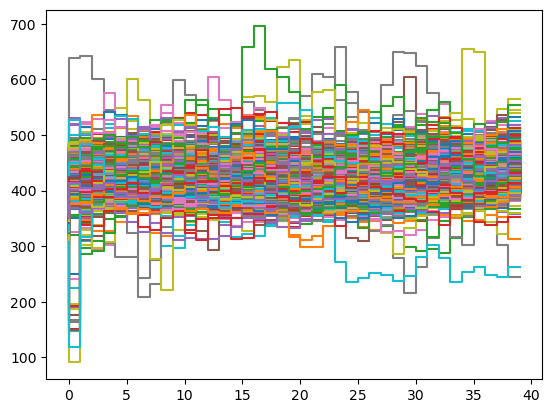

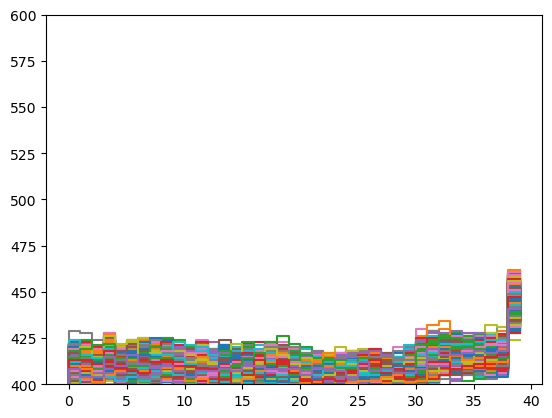

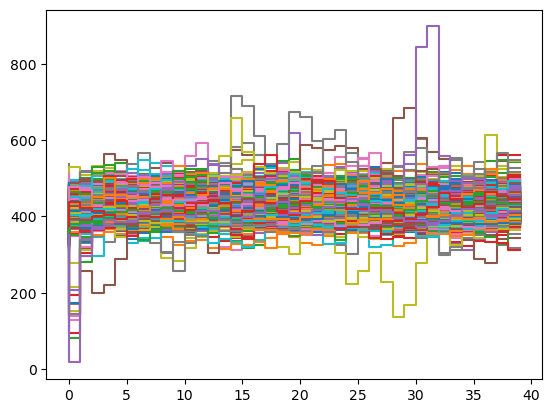

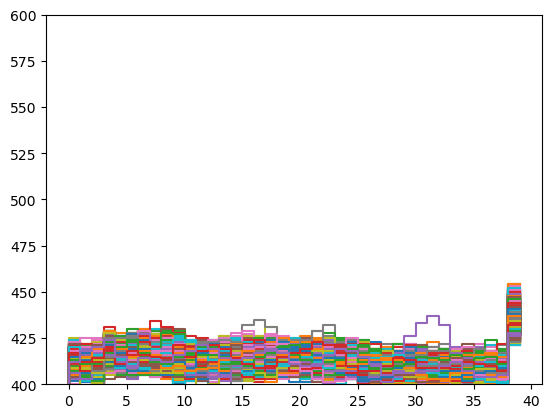

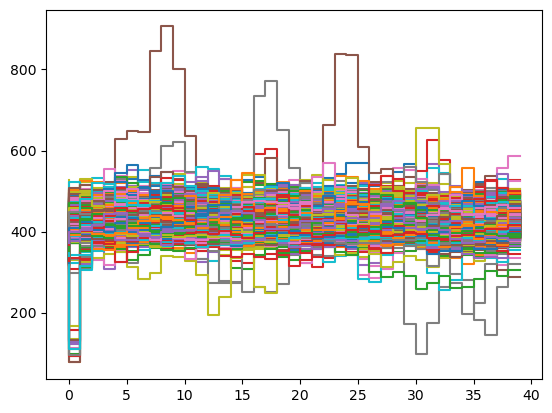

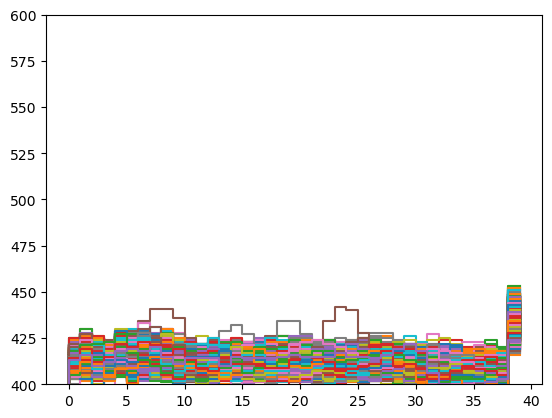

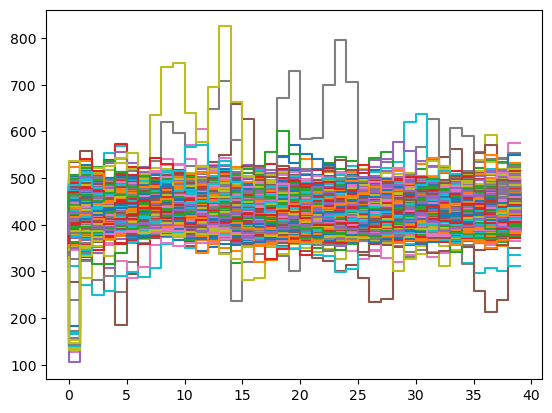

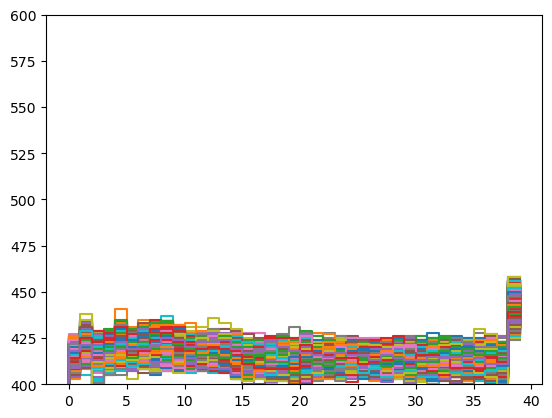

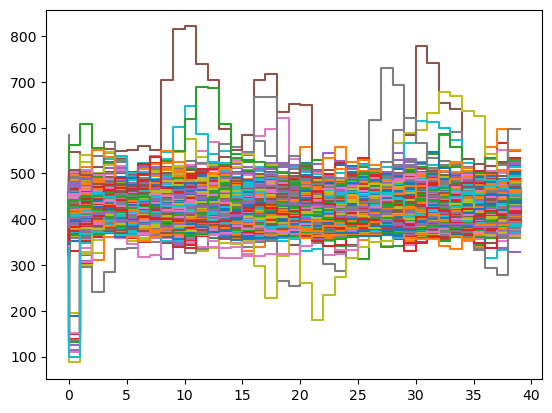

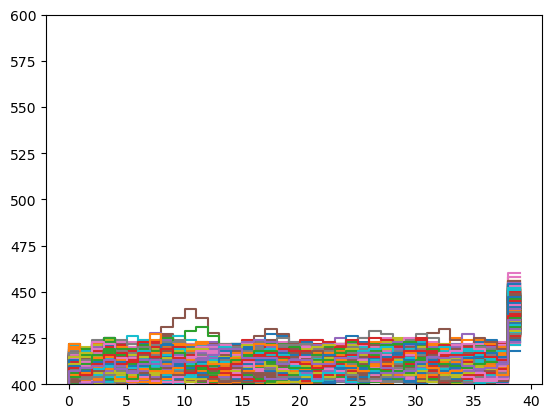

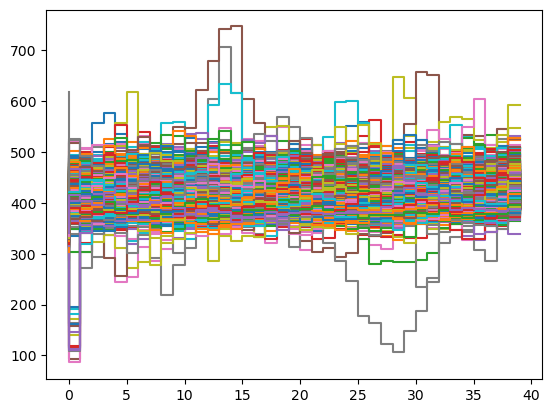

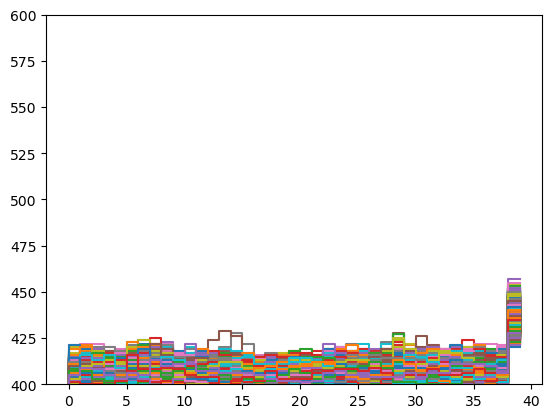

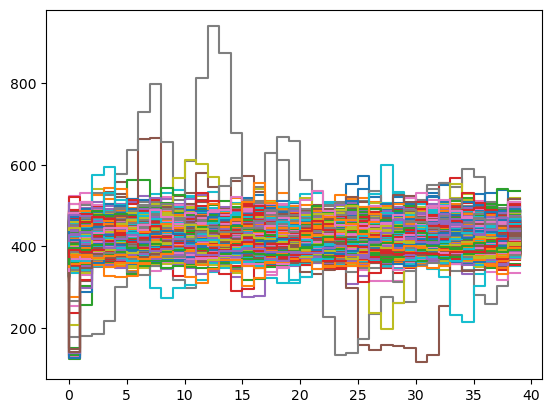

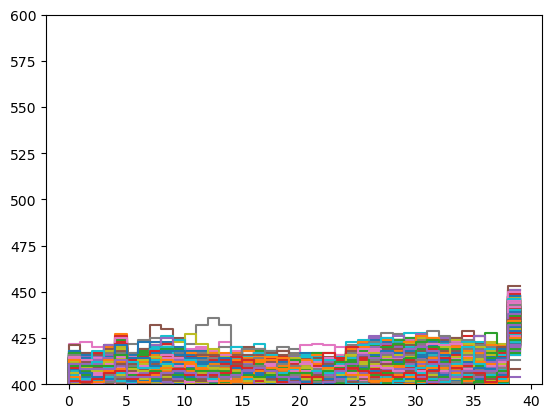

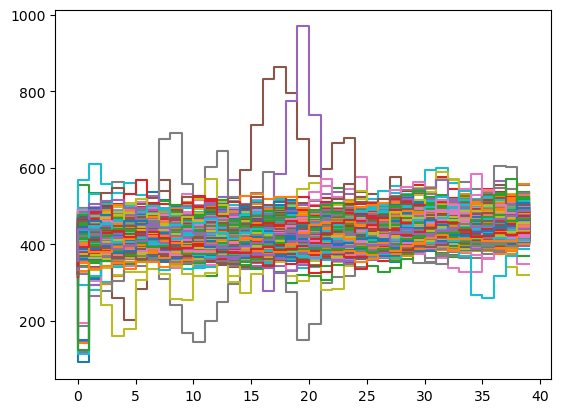

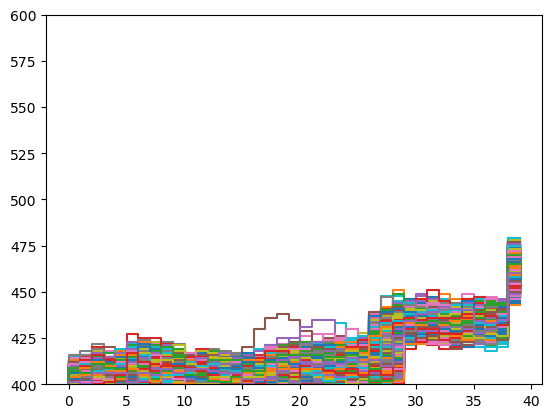

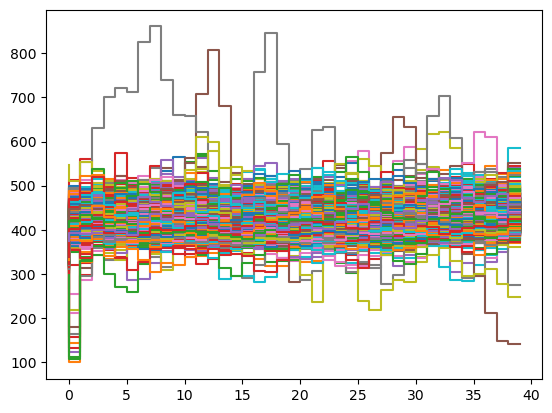

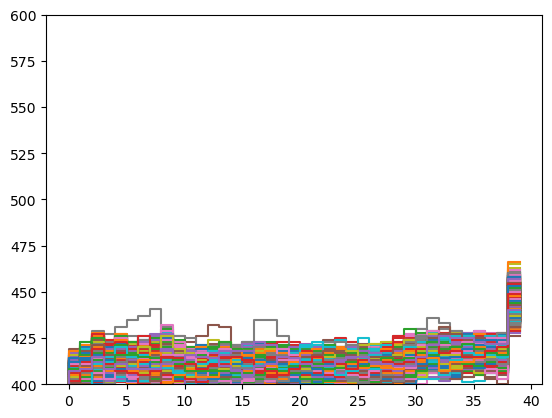

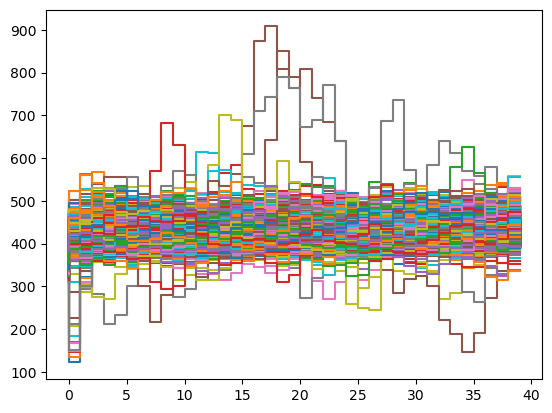

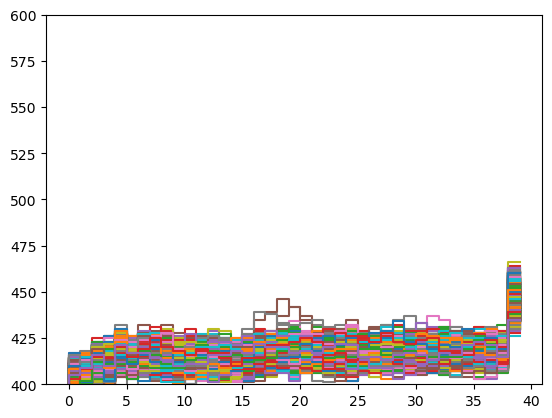

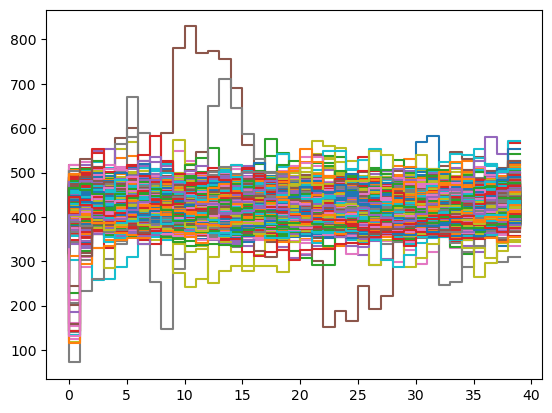

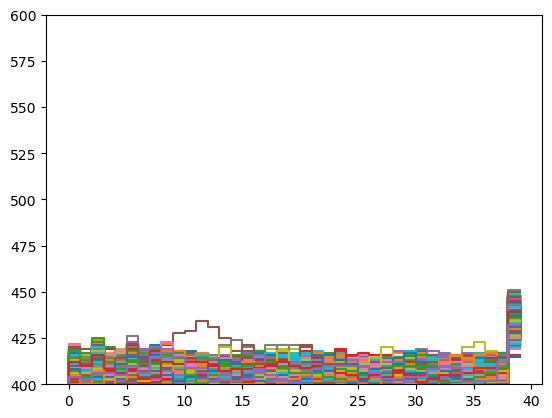

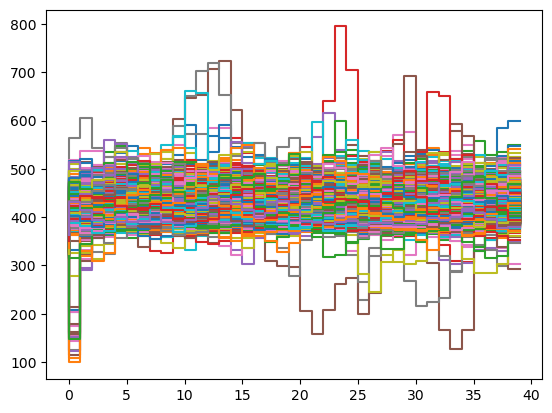

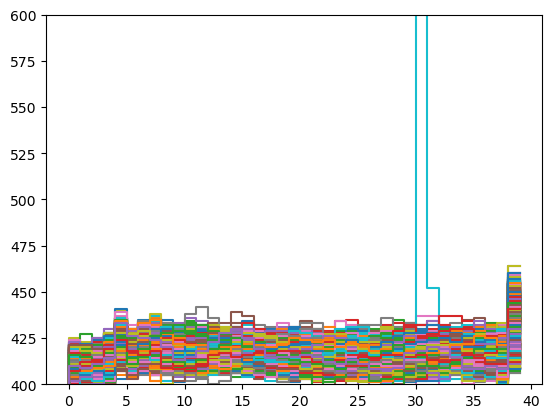

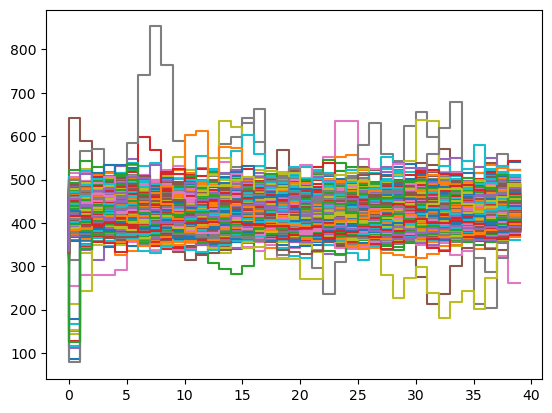

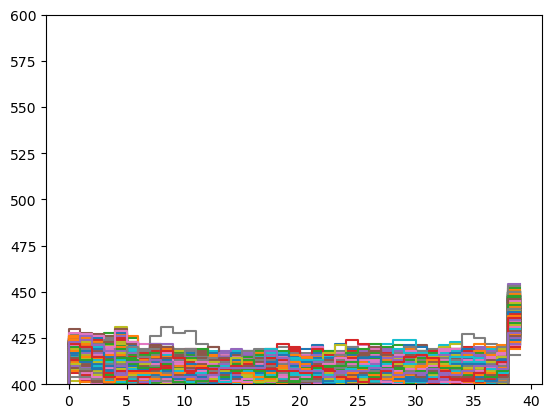

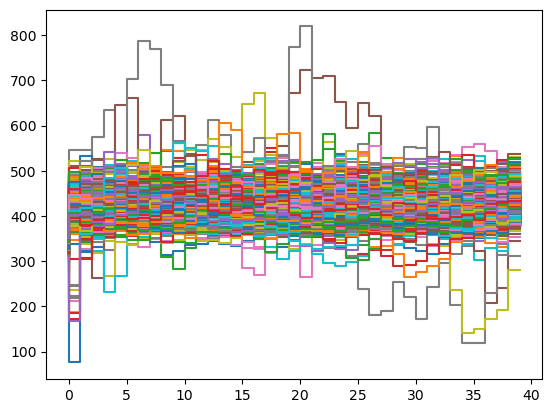

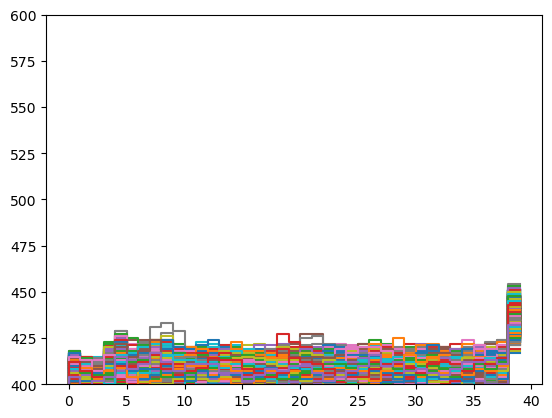

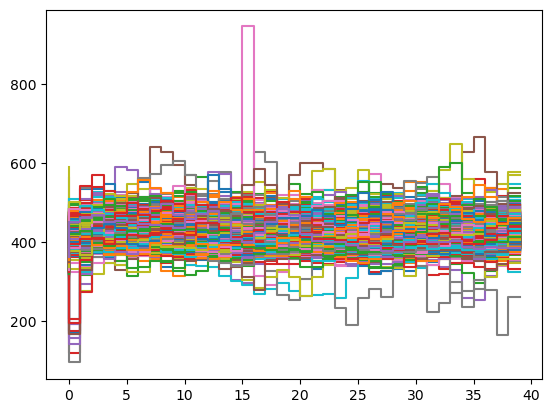

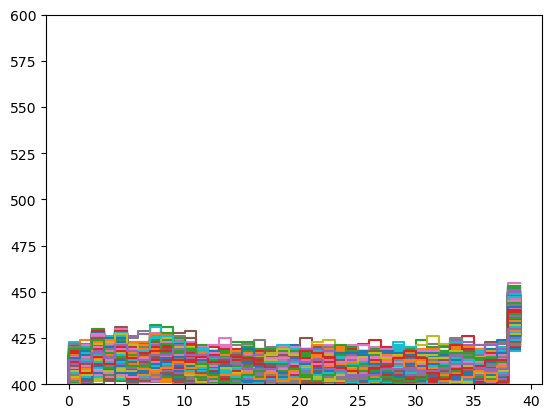

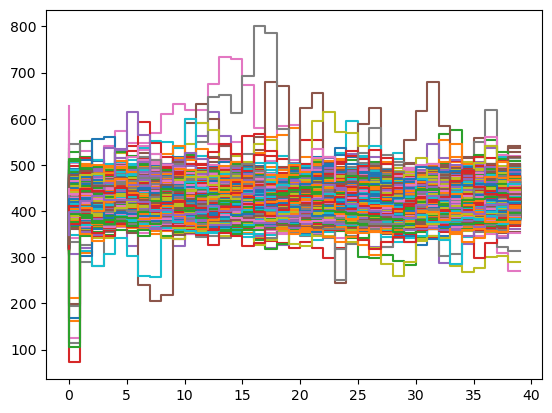

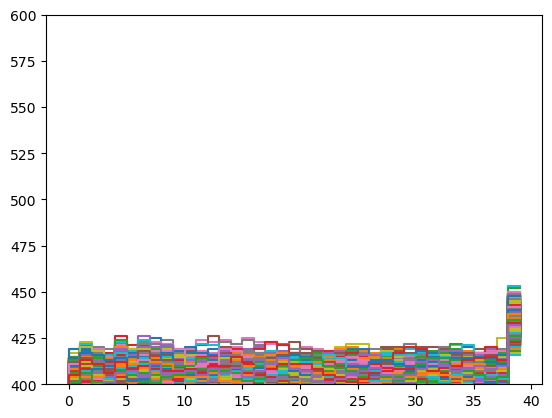

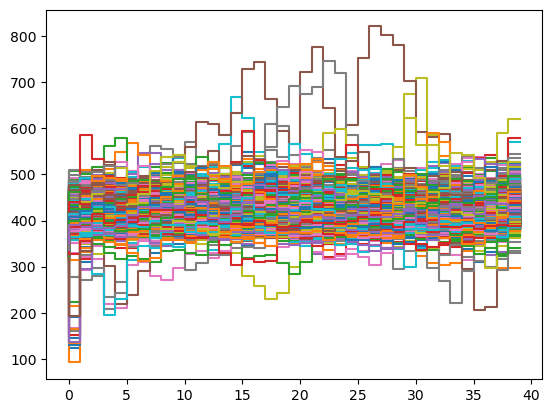

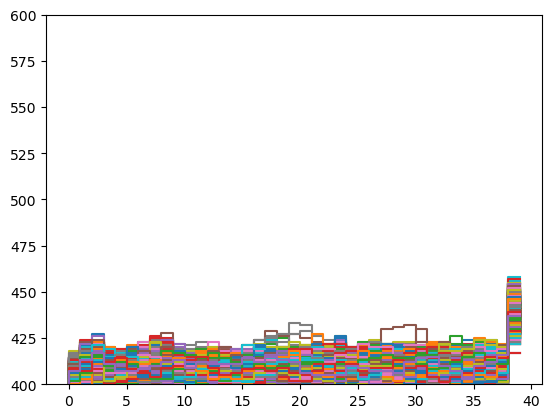

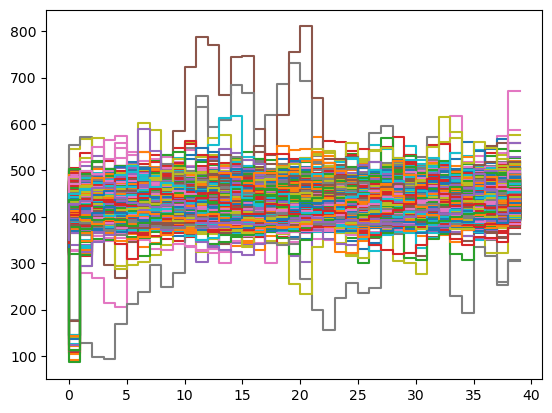

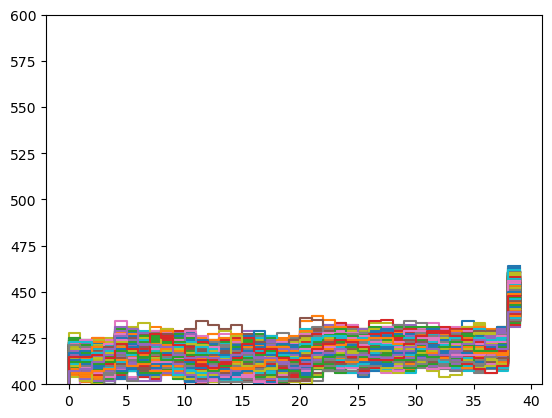

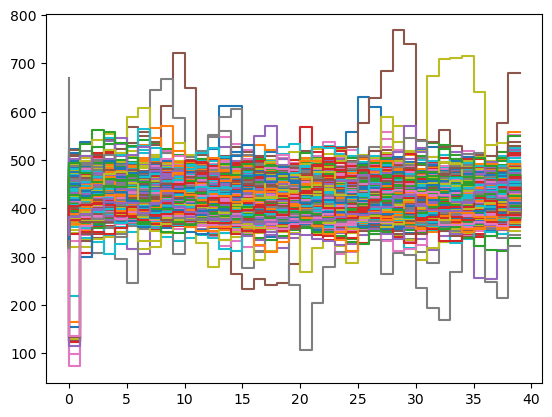

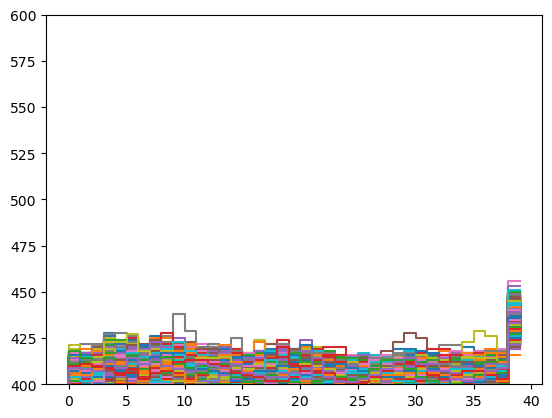

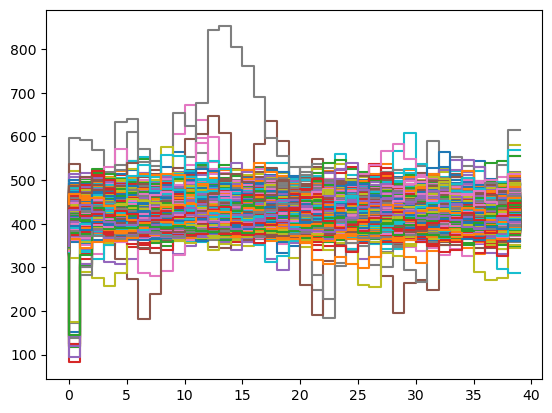

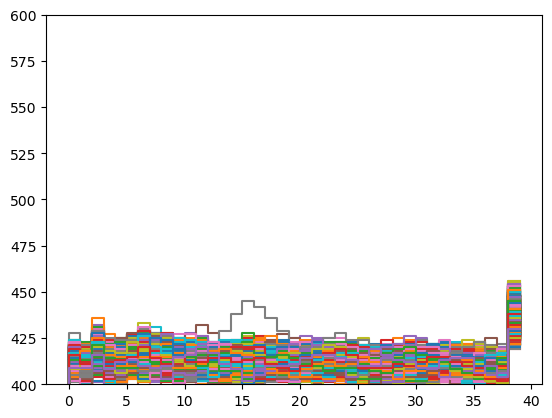

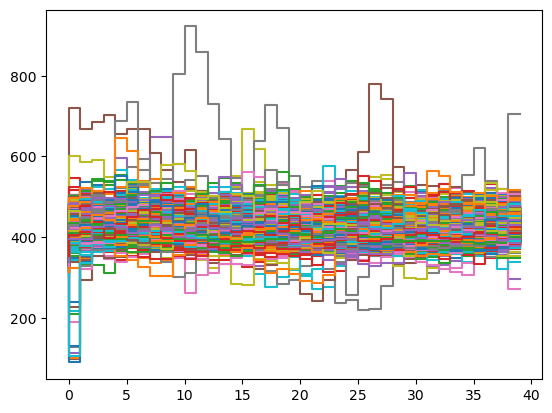

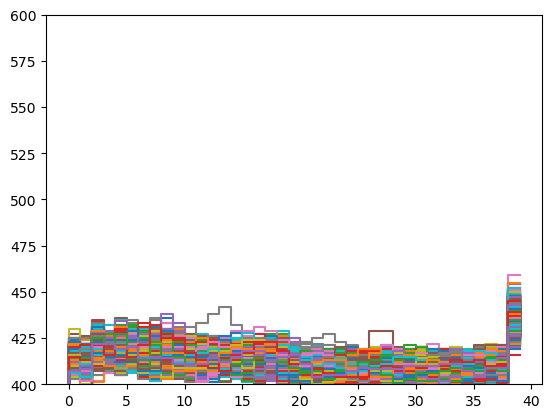

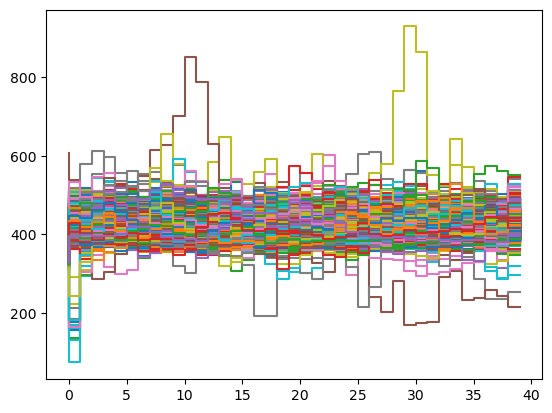

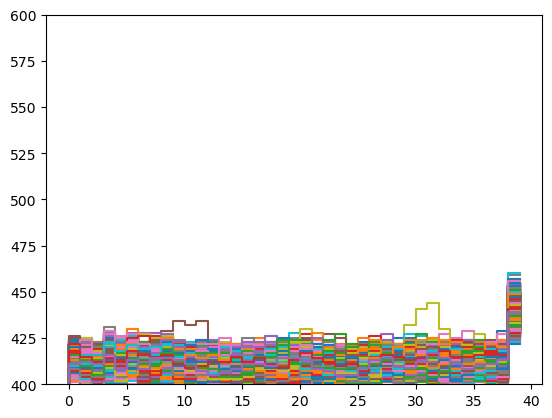

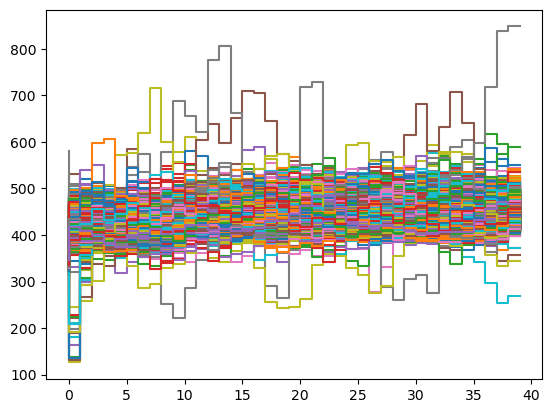

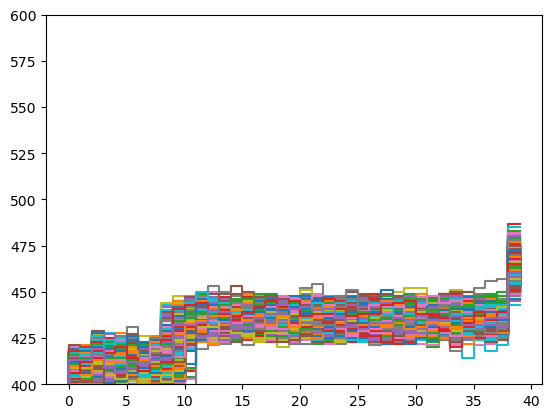

In [14]:
for i,event in enumerate(event_iterator):    
    for pix_id in range(0, 1855):
        plt.plot(
            event.r0.tel[1].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle="steps"
        )
    plt.show()
    for pix_id in range(0, 1855):
        plt.plot(
            event.r0.tel[1].waveform[1][pix_id], label="pix {}".format(pix_id), drawstyle="steps"
        )
        plt.ylim(400,600)
    plt.show()
    if i > 30:
        plt.close()
        break

In [41]:
event.r1.tel[1].waveform.shape

(1855, 36)

In [44]:
event.r0.tel[1].waveform[0].shape

(1855, 40)

In [46]:
# Треба завантажити конфіг в івент соурс
filename = f'/Users/vdk/CTA/RealLST/typical_run_data/LST-1.4.Run14948.0001.fits.fz'

#int_cut = 0.3
#min_pixel = 30

config_filename = '/Users/vdk/CTA/RealLST/typical_run_data/lstchain_standard_v0.10_heuristic_ff.json'
with open(config_filename) as json_file:
    config_data = json.load(json_file)

custom_config = Config(config_data)


cfg = Config({
    "source_config": {
        "EventSource" : {
            "allowed_tels": [1],"max_events": 9999}},
        "PointingSource":{
            "drive_report_path": '/Users/vdk/CTA/RealLST/typical_run_data/DrivePosition_log_20231007.txt'},
        "LSTR0Corrections": {
          "calib_scale_high_gain":1.088,
          "calib_scale_low_gain":1.004,
          "drs4_pedestal_path": '/Users/vdk/CTA/RealLST/typical_run_data/drs4_pedestal.Run14937.0000.h5',
          "calibration_path": '/Users/vdk/CTA/RealLST/typical_run_data/calibration_filters_52.Run14938.0000.h5',
          "drs4_time_calibration_path": '/Users/vdk/CTA/RealLST/typical_run_data/time_calibration.Run08349.0000.h5'
      }})

# config = replace_config(standard_config, muon_processor_config)
# config = replace_config(config, muon_processor_config_2)
# config = replace_config(config, custom_config)
source = EventSource(filename, config = Config(cfg))

event_iterator = iter(source)
event = next(event_iterator)

event.index.event_id

Calculating time reference values not from first event. This might result in wrong timestamps due to UCTS jumps
Using event 53004 as time reference for dragon. timestamp: 1696720155477297951 from ucts counter: 18477297700


53004

In [47]:
event.r1.tel[1].waveform.shape

(1855, 36)

In [48]:
event.r0.tel[1].waveform[0].shape

(1855, 40)